# Exploring upper bounds on k-mer differences based on hashes

Equiv? How long a run is the run without a hash.



In [4]:
import sourmash
import random

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
DNA = 'ATGC'

def generate_kmers(ksize):
    kmer = [ random.choice(DNA) for _ in range(ksize) ]
    while 1:
        random.shuffle(kmer)
        yield "".join(kmer)

In [ ]:
KSIZE = 31
SCALED = 100

runlengths = []
for i in range(int(100000)):
    if i % 1000 == 0:
        print('...', i)
    run = 0
    mh = sourmash.MinHash(n=0, ksize=KSIZE, scaled=SCALED)
    it = iter(generate_kmers(KSIZE))
    while not len(mh):
        kmer = next(it)
        mh.add_kmer(kmer)
        run += 1
    runlengths.append(run)

#print(runlengths)

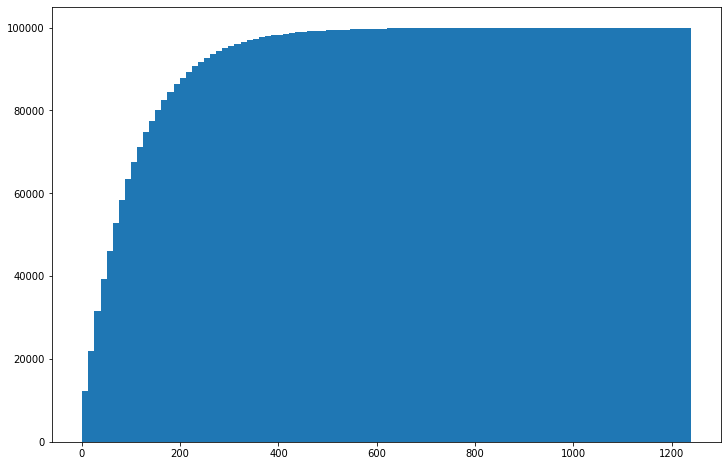

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.hist(runlengths, bins=100, cumulative=True)

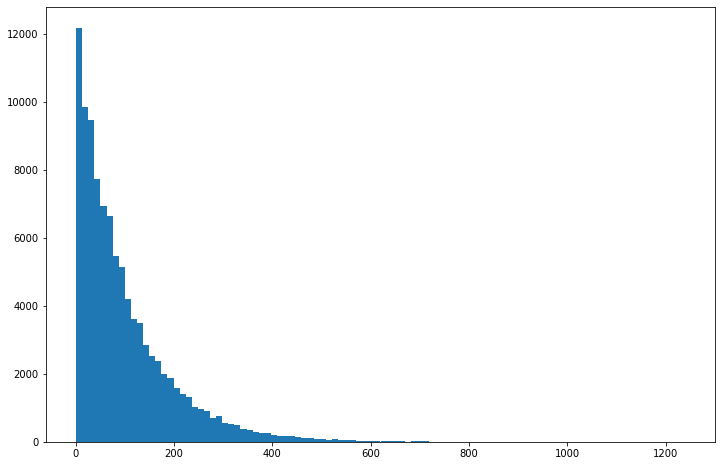

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.hist(runlengths, bins=100)

In [83]:
numpy.mean(runlengths)

100.32255

In [84]:
numpy.std(runlengths)

100.05102633905113

## thinking out loud

* two collections of k-mers of size N
* all hashes in common at SCALED
* what's the probability that they have no more than M different k-mers?

Intuition is that as M approaches SCALED, p <= 0.5

from poisson, as M => 5 x SCALED, p <= 0.9998 

that is, 99.98% of genomes of size N will have fewer than 5 \* SCALED k-mers different.

but... this can't be correct, this is independent of N? should it be?

yes, it only depends on SCALED? it's 1-the distribution above...

In [87]:
N_BINS = 20
n_notfound = [0] * N_BINS
for run in runlengths:
    for i in range(N_BINS):
        if run <= (i+1)*SCALED:
            n_notfound[i] += 1
            
for i in range(N_BINS):
    n_notfound[i] /= len(runlengths)

In [88]:
for i, val in enumerate(n_notfound):
    print(f"in M={(i+1) * SCALED} k-mers, p of finding at least one hash is: {val*100:.2f}% - scaled={SCALED}")

in M=100 k-mers, p of finding at least one hash is: 63.43% - scaled=100
in M=200 k-mers, p of finding at least one hash is: 86.51% - scaled=100
in M=300 k-mers, p of finding at least one hash is: 95.11% - scaled=100
in M=400 k-mers, p of finding at least one hash is: 98.18% - scaled=100
in M=500 k-mers, p of finding at least one hash is: 99.32% - scaled=100
in M=600 k-mers, p of finding at least one hash is: 99.72% - scaled=100
in M=700 k-mers, p of finding at least one hash is: 99.90% - scaled=100
in M=800 k-mers, p of finding at least one hash is: 99.96% - scaled=100
in M=900 k-mers, p of finding at least one hash is: 99.98% - scaled=100
in M=1000 k-mers, p of finding at least one hash is: 99.99% - scaled=100
in M=1100 k-mers, p of finding at least one hash is: 100.00% - scaled=100
in M=1200 k-mers, p of finding at least one hash is: 100.00% - scaled=100
in M=1300 k-mers, p of finding at least one hash is: 100.00% - scaled=100
in M=1400 k-mers, p of finding at least one hash is: 100.

## Using poisson as crosscheck

In [96]:
import math
for i in range(N_BINS):
    i = i+1
    print(f"M={i*SCALED} k-mers - p of at least one hash is: {(1 - math.exp(-i))*100:.2f}% - scaled={SCALED}")

M=100 k-mers - p of at least one hash is: 63.21% - scaled=100
M=200 k-mers - p of at least one hash is: 86.47% - scaled=100
M=300 k-mers - p of at least one hash is: 95.02% - scaled=100
M=400 k-mers - p of at least one hash is: 98.17% - scaled=100
M=500 k-mers - p of at least one hash is: 99.33% - scaled=100
M=600 k-mers - p of at least one hash is: 99.75% - scaled=100
M=700 k-mers - p of at least one hash is: 99.91% - scaled=100
M=800 k-mers - p of at least one hash is: 99.97% - scaled=100
M=900 k-mers - p of at least one hash is: 99.99% - scaled=100
M=1000 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1100 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1200 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1300 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1400 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1500 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1600 k-mers - p of at least one hash is: 100.00% - scale

## The theory

the probability of seeing exactly 0 hashes in a run of M k-mers with a scaled of SCALED is:

1 - the probability of seeing 0 hashes in a run of M k-mers with a scaled of SCALED,

which is 1 - Poisson(k=0, lambda=M / scaled)

which is 1 - e**(-M/scaled)

or in Python:

```
1 - math.exp(- (M/scaled))
```

which (per notebook ;) matches the distribution pretty darned well.

(the small deviations are either due to sampling statistics, or properties of murmurhash)

## Fun concluding notes

This distribution is dependent only on `M/scaled`, not `N` (size of genome).

This means for typical microbial genome sizes N=5e6 and a scaled of SCALED, there is a convenient estimate of upper bound for fraction of genome that will be different at a given scaled if all hashes are the same.


In [133]:
# FIXME

SCALED = 100
N = 5e6

for SCALED in (100, 500, 1000):
    for i in (10, 15, 20):
        M = i*SCALED
        p = (math.exp(1 - i))
        print(f"at scaled={SCALED}, ~{(p)*100:.4f}% of {N:g} bp genomes sharing all hashes are > ~{(M/N)*100:.2f}% different.")

at scaled=100, ~0.0123% of 5e+06 bp genomes sharing all hashes are > ~0.02% different.
at scaled=100, ~0.0001% of 5e+06 bp genomes sharing all hashes are > ~0.03% different.
at scaled=100, ~0.0000% of 5e+06 bp genomes sharing all hashes are > ~0.04% different.
at scaled=500, ~0.0123% of 5e+06 bp genomes sharing all hashes are > ~0.10% different.
at scaled=500, ~0.0001% of 5e+06 bp genomes sharing all hashes are > ~0.15% different.
at scaled=500, ~0.0000% of 5e+06 bp genomes sharing all hashes are > ~0.20% different.
at scaled=1000, ~0.0123% of 5e+06 bp genomes sharing all hashes are > ~0.20% different.
at scaled=1000, ~0.0001% of 5e+06 bp genomes sharing all hashes are > ~0.30% different.
at scaled=1000, ~0.0000% of 5e+06 bp genomes sharing all hashes are > ~0.40% different.


## let's rephrase

a genome difference of < 1% for 99.9% of genomes with all hashes same =>

N/SCALED hashes identical, whatever
99% of genome the same => .01 * N the same => runlength of .01 * N k-mers without a hash 

here (p = 1 - math.exp(1 - (.01 * N / SCALED))

so we want SCALED such that p =~ .001 = .01 * N / SCALED

or 
.1 = N / scaled

or 

scaled = 10 * N



here (p = 1 - math.exp(1 - (.01 * N / SCALED))
      
      
1 - p = math.exp(1 - (.01 * N / SCALED))

math.log(1-p) = 1 - (.01 * N / SCALED)

1 - math.log(1-p) = .01 * N / SCALED

SCALED = .01 * N / (1 - math.log(1-p))
      


In [147]:
.01 * N / (1 - math.log(1 - .001))

49950.02498334166

In [151]:
for N in 5e3, 5e4, 5e5, 5e6:
    N = int(N)
    print(f"for genome size {N:g}, need scaled={round(.01 * N / (1 - math.log(1 - .001)) + 0.5)} to guarantee that 99.9% of genomes with all hashes same => < 1% different")

for genome size 5000, need scaled=50 to guarantee that 99.9% of genomes with all hashes same => < 1% different
for genome size 50000, need scaled=500 to guarantee that 99.9% of genomes with all hashes same => < 1% different
for genome size 500000, need scaled=4996 to guarantee that 99.9% of genomes with all hashes same => < 1% different
for genome size 5e+06, need scaled=49951 to guarantee that 99.9% of genomes with all hashes same => < 1% different


or ...

for a given genome size N, need scaled = N/100 to guarantee that 99.9% of genomes with identical hashes are <1% different

or, back of napkin,

for p = .001, want f=>.001; .1 * N/scaled = .001 => .01 * N / scaled = 1 => scaled = N / 100

It also multiplies - for genome size 5e6 at a scaled of 5000, 99.9% of genomes with identical hashes are < 0.1% different.

(that is, divide scaled by 10 => divide difference by 10)